<a href="https://colab.research.google.com/github/meti-94/TextClassification/blob/main/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ## install finrl library
# !pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git -q
!git clone https://github.com/AI4Finance-LLC/FinRL-Library.git -q

In [2]:
%cd FinRL-Library/
!pip install -e . -q

/content/FinRL-Library
     |████████████████████████████████| 234 kB 21.0 MB/s 
     |████████████████████████████████| 176 kB 47.2 MB/s 
     |████████████████████████████████| 59.6 MB 76 kB/s 
     |████████████████████████████████| 1.8 MB 26.5 MB/s 
     |████████████████████████████████| 124 kB 53.4 MB/s 
     |████████████████████████████████| 147 kB 45.9 MB/s 
     |████████████████████████████████| 45 kB 3.2 MB/s 
     |████████████████████████████████| 2.4 MB 39.6 MB/s 
     |████████████████████████████████| 153 kB 50.8 MB/s 
     |████████████████████████████████| 195 kB 50.3 MB/s 
     |████████████████████████████████| 90.8 MB 291 bytes/s 
     |████████████████████████████████| 448 kB 44.4 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
     |████████████████████████████████| 3.6 MB 41.8 MB/s 
     |████████████████████████████████| 1.1 MB 42.2 MB/s 
     |████████████████████████████████| 271 kB 55.2 MB/s 
     |████████████████████████████████| 94 kB 3.4 M

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
from datetime import datetime
%matplotlib inline
from finrl.apps import config
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [5]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
def read_data(path):
    hist = pd.read_csv(path, parse_dates=True)
    hist = hist[hist.Timestamp>=1388521800]
    hist['date'] = hist['Timestamp'].apply(lambda item:datetime.fromtimestamp(item))
    hist.set_index('date', inplace=True)
    hist.dropna(inplace=True)
    return hist

def resampling(hist, timeframe='1min'):
    ohlc = {
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume_(BTC)':'sum'
    }
    df = hist.resample(timeframe, origin='end_day').apply(ohlc)
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    df.rename(columns={'Open':'open', 'High':'high', 'Close':'close', 'Low':'low', 'Volume_(BTC)':'volume'}, inplace=True)
    df['date'] = df['date'].astype(str)
    df['tic'] = ['BTC' for _ in range(len(df))]
    df['day'] = [i%5 for i in range(len(df))]
    return df   
hist = read_data('/content/drive/MyDrive/kaggle_dataset/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
hist = hist['2014-01-01' :'2021-03-30']
hist = resampling(hist, timeframe='D')
df = hist

In [8]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2014-01-01,732.00,732.00,732.00,732.00,4.599562,BTC,0
1,2014-01-02,732.01,757.99,729.01,754.90,7903.038301,BTC,1
2,2014-01-03,751.88,798.70,742.50,784.19,15134.172831,BTC,2
3,2014-01-04,784.12,818.99,767.62,809.40,14860.259005,BTC,3
4,2014-01-05,808.24,830.00,790.20,828.83,11004.642948,BTC,4


In [9]:
df.tail()

,date,open,high,low,close,volume,tic,day
2639,2021-03-27,51372.34,55300.00,51372.34,55261.73,4881.915299,BTC,4
2640,2021-03-28,55295.63,56686.15,53948.35,55920.82,2601.956453,BTC,0
2641,2021-03-29,55946.79,56573.04,54677.51,55804.36,2074.410637,BTC,1
2642,2021-03-30,55822.98,58402.68,54892.42,57670.58,5363.655852,BTC,2
2643,2021-03-31,57582.17,59388.66,57011.00,58760.59,3387.376981,BTC,3


In [10]:
df.shape

(2644, 8)

In [11]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2014-01-01,732.00,732.00,732.00,732.00,4.599562,BTC,0
1,2014-01-02,732.01,757.99,729.01,754.90,7903.038301,BTC,1
2,2014-01-03,751.88,798.70,742.50,784.19,15134.172831,BTC,2
3,2014-01-04,784.12,818.99,767.62,809.40,14860.259005,BTC,3
4,2014-01-05,808.24,830.00,790.20,828.83,11004.642948,BTC,4


In [12]:
len(df.tic.unique())

1

In [13]:
df.tic.value_counts()

BTC    2644
Name: tic, dtype: int64

In [14]:
tech_indicators = ['macd',
 'rsi_30',
 'cci_30',
 'dx_30']

In [15]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = tech_indicators,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [16]:
processed.sample(5)

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,turbulence
2371,2020-07-02,9123.79,9300.00,9089.80,9233.38,4316.326657,BTC,1,-71.054939,50.898507,-79.132701,19.724121,0.049018
2582,2021-01-29,30537.57,33870.58,29899.99,33466.63,17866.971031,BTC,2,267.315593,56.410857,-43.134880,16.984230,7.554245
249,2014-09-07,477.64,485.00,477.16,479.99,2763.952101,BTC,4,-19.019374,39.520419,-83.533340,24.838804,0.000000
2622,2021-03-10,52490.28,55055.00,51857.00,55004.38,5453.880582,BTC,2,1897.662395,63.093542,127.750716,26.092437,1.187157
65,2014-03-07,669.00,675.71,650.00,669.62,10401.363572,BTC,0,-12.431574,48.745062,45.503510,16.972612,0.000000


In [17]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(tech_indicators)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 1, State Space: 7


In [18]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicators,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

In [19]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

train_start = '2014-01-01'
train_end = '2018-9-30'
val_test_start = '2018-9-30'
val_test_end = '2020-01-30'

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(train_start,train_end),
                 val_test_period=(val_test_start,val_test_end),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)

In [20]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.01,
                    'learning_rate': 0.0005
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 64
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 100_000,
                      "learning_rate": 0.000005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 30_000, 
                 'ppo' : 100_000, 
                 'ddpg' : 10_000
                 }


timesteps_dict = {'a2c' : 10_000, 
                 'ppo' : 10_000, 
                 'ddpg' : 10_000
                 }

In [21]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  13.795470067925176
======Model training from:  2014-01-01 to  2019-01-01
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_1
---------------------------------------
| time/                 |             |
|    fps                | 77          |
|    iterations         | 100         |
|    time_elapsed       | 6           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -1.44       |
|    explained_variance | -0.0195     |
|    learning_rate      | 0.0005      |
|    n_updates          | 99          |
|    policy_loss        | -1.08       |
|    reward             | -0.45696354 |
|    std                | 1.02        |
|    value_loss         | 0.596       |
---------------------------------------
-------------------------------------
| time/                 |         

In [22]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2019-01-01,2019-03-05,DDPG,-0.104089,-0.242652,0.0
1,189,2019-03-05,2019-05-07,DDPG,0.464265,0.41192,0.467534
2,252,2019-05-07,2019-07-09,PPO,0.42111,0.504998,0.484258
3,315,2019-07-09,2019-09-10,A2C,0.046418,-0.000902,0.0
4,378,2019-09-10,2019-11-12,DDPG,-0.384582,-0.570052,0.0


In [23]:
unique_trade_date = processed[(processed.date > '2020-01-30')&(processed.date <= '2021-03-30')].date.unique()

In [24]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  0.9043399733020471


In [25]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1000000.0,2019-03-05,NaN,2020-04-03
1,1000000.0,2019-03-06,0.0,2020-04-04
2,1000000.0,2019-03-07,0.0,2020-04-05
3,1000000.0,2019-03-08,0.0,2020-04-06
4,1000000.0,2019-03-09,0.0,2020-04-07


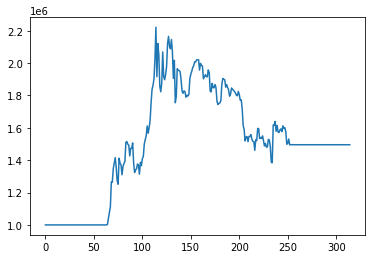

In [26]:
%matplotlib inline
df_account_value.account_value.plot()

In [28]:
print("==============Get Backtest Results===========")
now = datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.379741
Cumulative returns     0.495365
Annual volatility      0.485966
Sharpe ratio           0.904340
Calmar ratio           1.007182
Stability              0.282595
Max drawdown          -0.377034
Omega ratio            1.250185
Sortino ratio          1.434331
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.303463
Daily value at risk   -0.059482
dtype: float64


In [29]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (217, 8)
Annual return          0.137011
Cumulative returns     0.116913
Annual volatility      0.118038
Sharpe ratio           1.152122
Calmar ratio           1.983440
Stability              0.642470
Max drawdown          -0.069077
Omega ratio            1.223509
Sortino ratio          1.560294
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.003956
Daily value at risk   -0.014332
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (217, 8)


Start date,2019-03-05
End date,2020-01-13
Total months,15
,Backtest
Annual return,37.974%
Cumulative returns,49.536%
Annual volatility,48.597%
Sharpe ratio,0.90
Calmar ratio,1.01
Stability,0.28
Max drawdown,-37.703%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,37.70,2019-06-27,2019-10-25,NaT,NaN
1,13.27,2019-05-28,2019-06-10,2019-06-16,14
2,11.59,2019-05-16,2019-05-19,2019-05-27,8
3,2.79,2019-06-18,2019-06-19,2019-06-21,4
4,0.10,2019-05-12,2019-05-13,2019-05-14,2


Stress Events,mean,min,max
New Normal,0.17%,-13.76%,16.84%


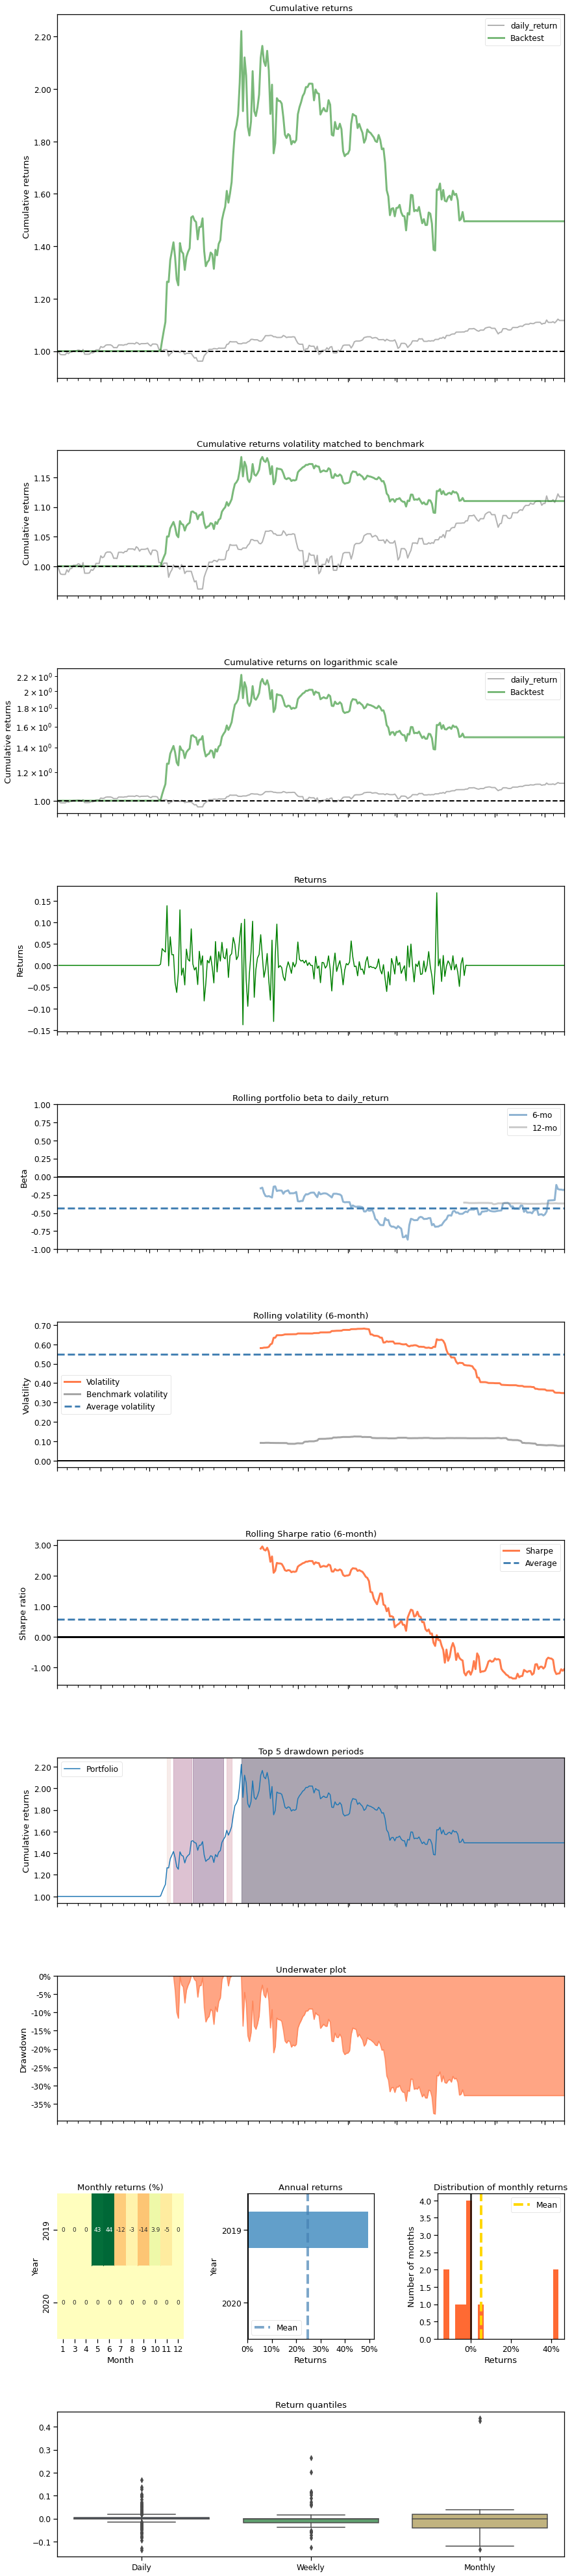

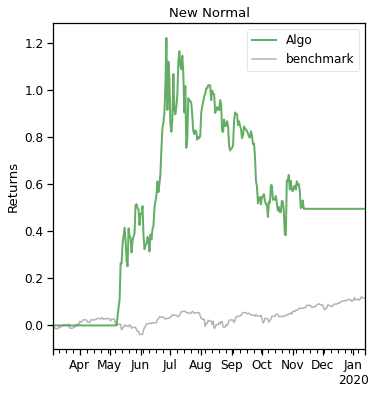

In [30]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])